# Smarter clustering

See if we can cluster based on GIS technology. There are a few reasons to do this: 
1) explainability: Points get assigned to routes because they are IN the polygon. 
2) Updateability: roadworks, LEZ, Circulation plans... zones can be excluded from specific routes to avoid these.
3) extendability: No data no model? No problem with this approach: just make a polygon and assign the polygon to a route. :)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import math

sys.path.append('../utils')
import helpers as h
import feature_engineering as f


try:
    import geopandas as gpd
except:
    ! pip install geopandas

try: 
    import scipy as sp 
except:
    ! pip install scipy

try: 
    from ortools.constraint_solver import routing_enums_pb2
    from ortools.constraint_solver import pywrapcp

except:
    ! pip install ortools


from polycluster import RoutePolygonManager
import plotly.graph_objects as go
from shapely.geometry import mapping

load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\ortools.dll...


In [3]:
ITM_DIR = os.path.join(os.getcwd(), '../data/intermediate')
request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))


C:\Users\Frede\AppData\Local\Temp\ipykernel_29820\3080534967.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))


## Metrics: 
We will not use driver preference as a metric here, in stead we will use the route distance as a metric. This route distance directly correlates to costs, and there is strong reason to believe that outliers are not favoured by drivers. As such a shorter route (with less outliers) is indirectly preferred by the driver. An outcome of polygon based clustering is effective if the routes are not longer and if no clustering requests to the server are needed - polygon based clustering is very efficient; we will show a benchmark too.

In [4]:
request_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,Date,Time,OptimizationRequestId,RouteId,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last
0,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,394,0.565826,0.221868,2022-06-17T07:30:00,2022-06-17T18:00:00,2,1,0521_300-20220617,...,2022-06-17 00:00:00,1900-01-01 05:57:33.231000,41931cd2-8975-4a64-9197-d16abe871bb7,0521_300,FullOptimization,CreateSequence,2.0,0.0,1.0,False
1,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,395,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,1,2,0521_300-20220617,...,2022-06-17 00:00:00,1900-01-01 05:57:33.231000,41931cd2-8975-4a64-9197-d16abe871bb7,0521_300,FullOptimization,CreateSequence,2.0,0.0,1.0,False
2,5737d4ef-23e9-4832-8bb5-24340a176e31,CreateSequence,384,0.565826,0.221868,2022-06-17T07:30:00,2022-06-17T23:59:00,2,1,0521_300-20220617,...,2022-06-17 00:00:00,1900-01-01 08:50:02.773000,5737d4ef-23e9-4832-8bb5-24340a176e31,0521_300,FullOptimization,CreateSequence,2.0,0.0,2.0,False
3,5737d4ef-23e9-4832-8bb5-24340a176e31,CreateSequence,385,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,1,2,0521_300-20220617,...,2022-06-17 00:00:00,1900-01-01 08:50:02.773000,5737d4ef-23e9-4832-8bb5-24340a176e31,0521_300,FullOptimization,CreateSequence,2.0,0.0,2.0,False
4,34f409b3-9f92-4720-9926-48ca1cbf6f90,CreateSequence,388,0.572716,0.233306,2022-06-17T07:30:00,2022-06-17T23:59:00,2,1,0521_300-20220617,...,2022-06-17 00:00:00,1900-01-01 09:24:16.831000,34f409b3-9f92-4720-9926-48ca1cbf6f90,0521_300,FullOptimization,CreateSequence,2.0,0.0,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120926,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63699,0.480072,0.301707,2022-06-22T07:30:00,2022-06-22T23:59:00,135,135,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,5.0,True
2120927,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63698,0.479680,0.301925,2022-06-22T07:30:00,2022-06-22T23:59:00,136,136,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,5.0,True
2120928,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63697,0.479792,0.300703,2022-06-22T07:30:00,2022-06-22T23:59:00,137,137,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,5.0,True
2120929,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63696,0.481527,0.300490,2022-06-22T07:30:00,2022-06-22T23:59:00,138,138,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,5.0,True


In [5]:
## Get average route distances (from helper tool)
request_df = f.calculate_distances(request_df, 'stop_order')


100%|██████████| 18010/18010 [00:21<00:00, 857.59it/s] 


In [6]:
driven_df = request_df.query('request_day_route_is_last==True')

In [7]:
baseline_distances = driven_df.groupby('file_uuid').max('dist_cumulative')

In [8]:
request_df_unique = request_df[['file_uuid', 'route_id', 'route_date']].drop_duplicates(subset='file_uuid', keep='first')
merged_df = pd.merge(baseline_distances, request_df_unique, how='left', on='file_uuid')

In [9]:
merged_df

,file_uuid,lat,long,server_task_number,stop_order,idblock_1,idblock_2,idblock_3,internal_id,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last,dist_since_prev,dist_cumulative,dist_to_next_stop,route_id,route_date
0,00128b2f-a748-4521-a779-c95622aadbe9,0.693922,0.224376,139,139,64026,139,139,6491,139.0,139.0,5.0,True,0.005760,0.127868,0.005760,0521_616,2022-06-21
1,002030bf-edc1-4b11-9000-ee8efcb42a99,0.505869,0.260552,44,44,80529,44,44,19038,44.0,44.0,4.0,True,0.067820,0.111656,0.067820,0521_O16,2022-06-17
2,00332dbb-8cfb-4752-b7c5-a1d3daf3322d,0.650488,0.312991,142,142,64156,142,142,118,142.0,142.0,4.0,True,0.006229,0.113777,0.006229,0521_301,2022-06-21
3,003d67fe-b69f-4ea8-95f1-b91e45b8f942,0.534880,0.241965,141,141,54840,141,141,4140,141.0,141.0,5.0,True,0.004764,0.071350,0.004764,0521_370,2022-06-08
4,004d24a9-8c75-4806-9a6d-2e7f9f2d7ad4,0.638021,0.235744,95,95,73352,95,95,14740,95.0,95.0,9.0,True,0.017459,0.181089,0.017459,0521_867,2022-06-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,ff63f4da-fa32-45fe-b9ea-39103a846a50,0.593930,0.157672,93,93,63738,93,93,1449,93.0,93.0,5.0,True,0.004071,0.074395,0.004071,0521_318,2022-06-03
3307,ff92d4cf-f021-4c9e-8f3f-be0856917c67,0.498214,0.178268,47,47,74602,47,47,21211,47.0,47.0,7.0,True,0.004789,0.091189,0.004789,0521_O60,2022-06-04
3308,ff936809-b189-4ccf-969b-27fb14742dd6,0.547042,0.536197,77,77,71014,77,77,18018,77.0,77.0,6.0,True,0.019093,0.316329,0.019093,0521_B04,2022-06-09
3309,ffb1a682-917b-4f75-858e-157dce75d3ee,0.517656,0.536233,129,129,63006,129,129,2334,129.0,129.0,7.0,True,0.035892,0.335090,0.035892,0521_352,2022-06-17


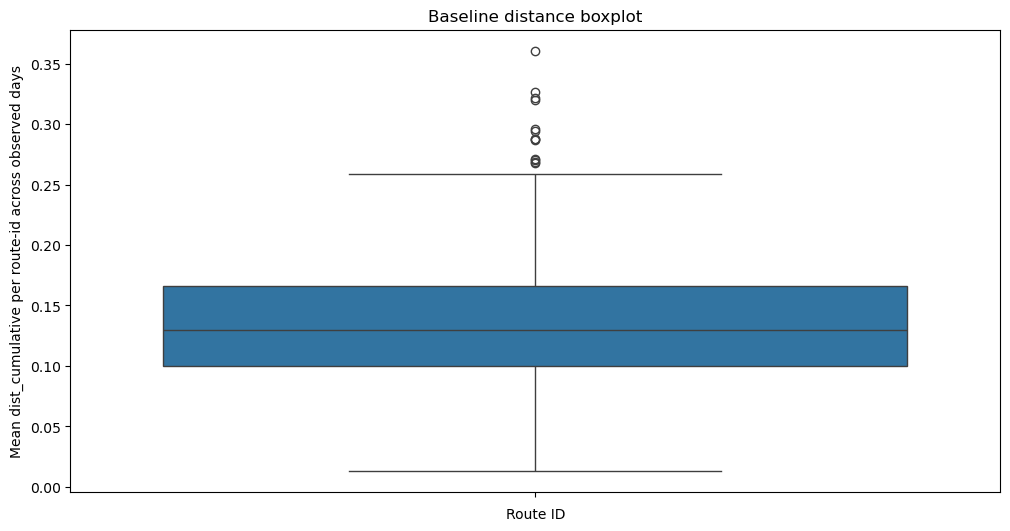

In [10]:
# Calculate the mean dist_cumulative grouped by route_id
mean_dist_cumulative = merged_df.groupby('route_id')['dist_cumulative'].mean().reset_index()
# # Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=mean_dist_cumulative, y='dist_cumulative')
plt.xticks(rotation=90)
plt.title('Baseline distance boxplot')
plt.xlabel('Route ID')
plt.ylabel('Mean dist_cumulative per route-id across observed days')
plt.show()

## make polygons
Get the actual driven routes and turn them into polygons. If we just make a line around all our points, then we still have polygons that are susceptible to outliers; in stead we need to generate one polygon per route_id per day. Overlay all days per route_id and average it out. Points that are out a lot or only occur once will not occur in other days and are thus deleted from the  averaged polygon. 

In a 1D you can interpret it like this: 
```
- Day1:  -       --------------------      -
- Day2:  -          -------------
- Day3:   ---------------    ----
- Day4:         --------------------
- Day5:    ----------------------
```

If you'd take the full range you'd have the outlier that's at the end of day1: by overlaying day1 to day 5 and removing low-occuring zones, you can excluded the day1 outlier from the polygon for a given route id. :)


In [11]:
full_finaldriven = []
dayroutename = 'route_day_id'
for _, df in request_df.groupby('dir'):
    #Time is the timestamp coming from serverlog: compare first request wiht last non-PM request
    # REMEMBER THAT: PM requests where filtered out already.
    last_request_timestamp = df['Time'].max()
    #get the first and last request as dfs: 
    last_request_df = df.loc[df['Time'] == last_request_timestamp]
    full_finaldriven.append(last_request_df)

full_finaldriven_df = pd.concat(full_finaldriven)
full_finaldriven_df[dayroutename] = full_finaldriven_df['route_id']+'__'+full_finaldriven_df['route_date']

In [12]:
full_finaldriven_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last,dist_since_prev,dist_cumulative,dist_to_next_stop,route_day_id
4,34f409b3-9f92-4720-9926-48ca1cbf6f90,CreateSequence,388,0.572716,0.233306,2022-06-17T07:30:00,2022-06-17T23:59:00,2,1,0521_300-20220617,...,FullOptimization,CreateSequence,2.0,0.0,3.0,True,0.000000,0.000000,0.013353,0521_300__2022-06-17
5,34f409b3-9f92-4720-9926-48ca1cbf6f90,CreateSequence,390,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,1,2,0521_300-20220617,...,FullOptimization,CreateSequence,2.0,0.0,3.0,True,0.013353,0.013353,NaN,0521_300__2022-06-17
6,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64869,0.650488,0.296025,2022-05-30T00:00:00,2022-05-30T12:00:00,1,1,0521_301-20220530,...,TimeCalculation,EstimateTime,154.0,154.0,1.0,True,0.000000,0.000000,0.004470,0521_301__2022-05-30
7,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64947,0.646361,0.297741,2022-05-30T00:00:00,2022-05-30T12:00:00,2,2,0521_301-20220530,...,TimeCalculation,EstimateTime,154.0,154.0,1.0,True,0.004470,0.004470,0.000907,0521_301__2022-05-30
8,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64971,0.645787,0.298443,2022-05-30T00:00:00,2022-05-30T12:00:00,3,3,0521_301-20220530,...,TimeCalculation,EstimateTime,154.0,154.0,1.0,True,0.000907,0.005377,0.000000,0521_301__2022-05-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120926,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63699,0.480072,0.301707,2022-06-22T07:30:00,2022-06-22T23:59:00,135,135,0521_O69-20220622,...,TimeCalculation,EstimateTime,139.0,139.0,5.0,True,0.001027,0.131226,0.000448,0521_O69__2022-06-22
2120927,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63698,0.479680,0.301925,2022-06-22T07:30:00,2022-06-22T23:59:00,136,136,0521_O69-20220622,...,TimeCalculation,EstimateTime,139.0,139.0,5.0,True,0.000448,0.131674,0.001227,0521_O69__2022-06-22
2120928,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63697,0.479792,0.300703,2022-06-22T07:30:00,2022-06-22T23:59:00,137,137,0521_O69-20220622,...,TimeCalculation,EstimateTime,139.0,139.0,5.0,True,0.001227,0.132901,0.001749,0521_O69__2022-06-22
2120929,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63696,0.481527,0.300490,2022-06-22T07:30:00,2022-06-22T23:59:00,138,138,0521_O69-20220622,...,TimeCalculation,EstimateTime,139.0,139.0,5.0,True,0.001749,0.134650,0.002376,0521_O69__2022-06-22


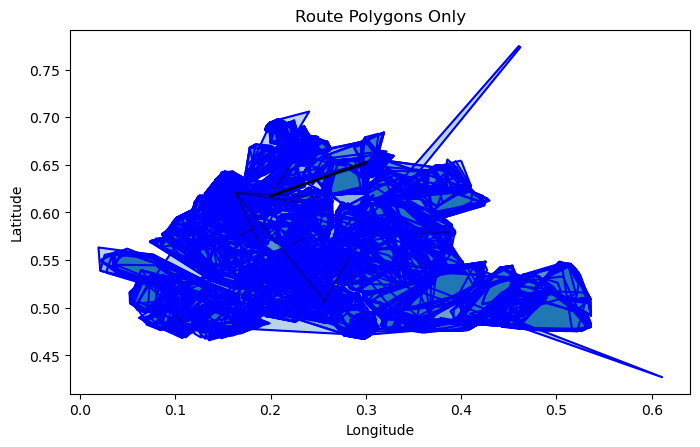

In [13]:
rpm = RoutePolygonManager(full_finaldriven_df)
rpm.create_polygons(latcol = 'lat', longcol = 'long', cluster_id = dayroutename)
rpm.plot_polygons()

c:\Practical Business Python\Year 2\projecten\learning-driver-preferences\notebooks\../utils\polycluster.py:176: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([geom]).boundary.plot(ax=ax, color='blue', linewidth=1)


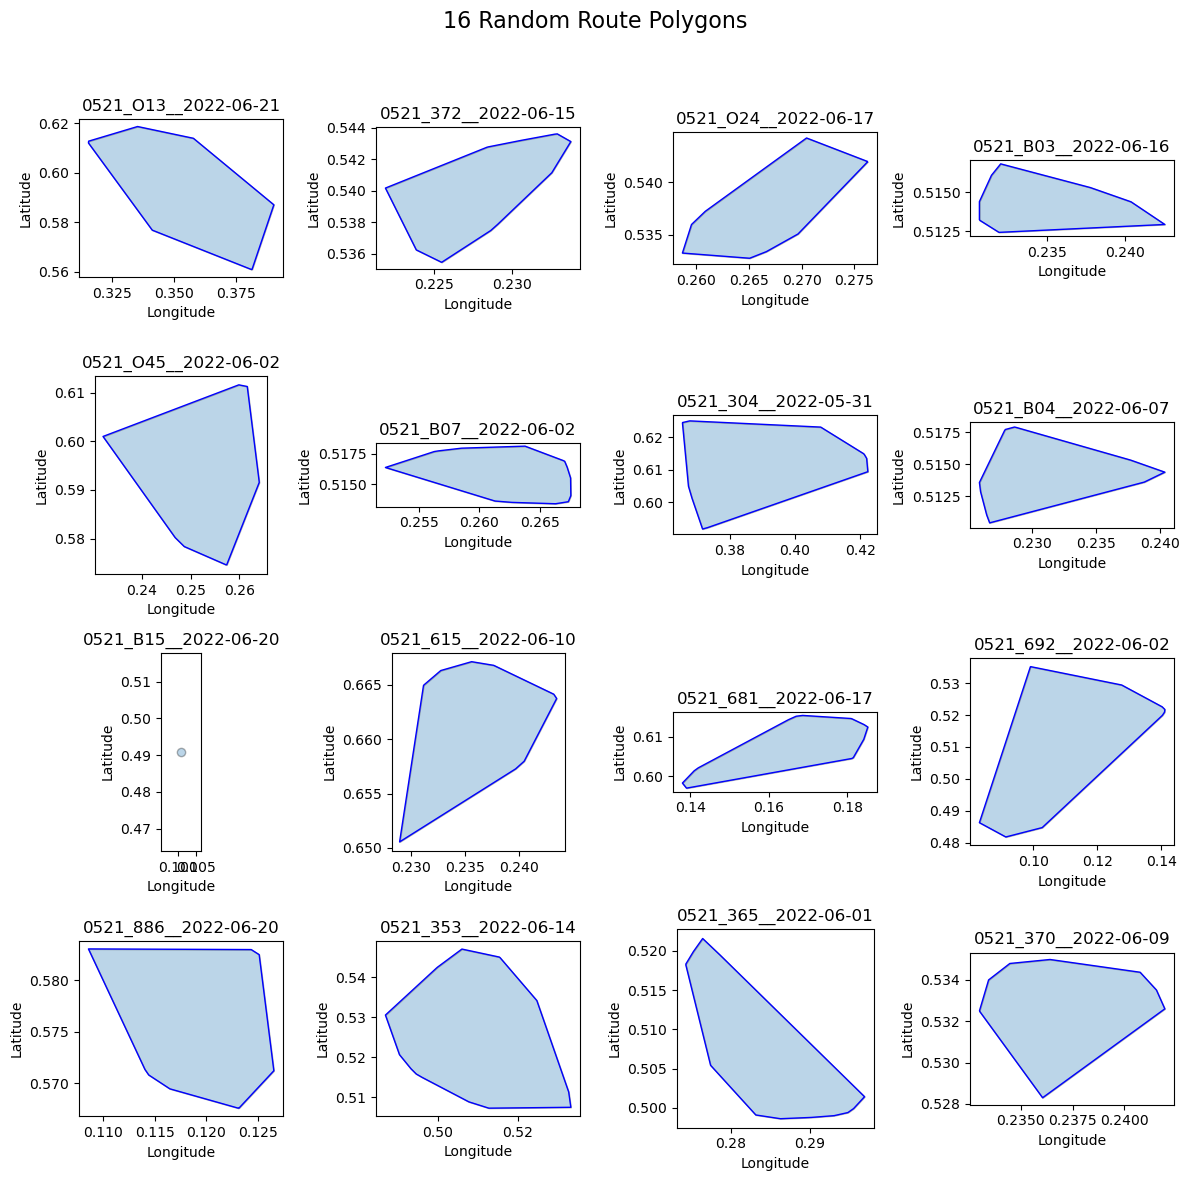

In [14]:
rpm.plot_random_polygons_grid(4, keyname = dayroutename)

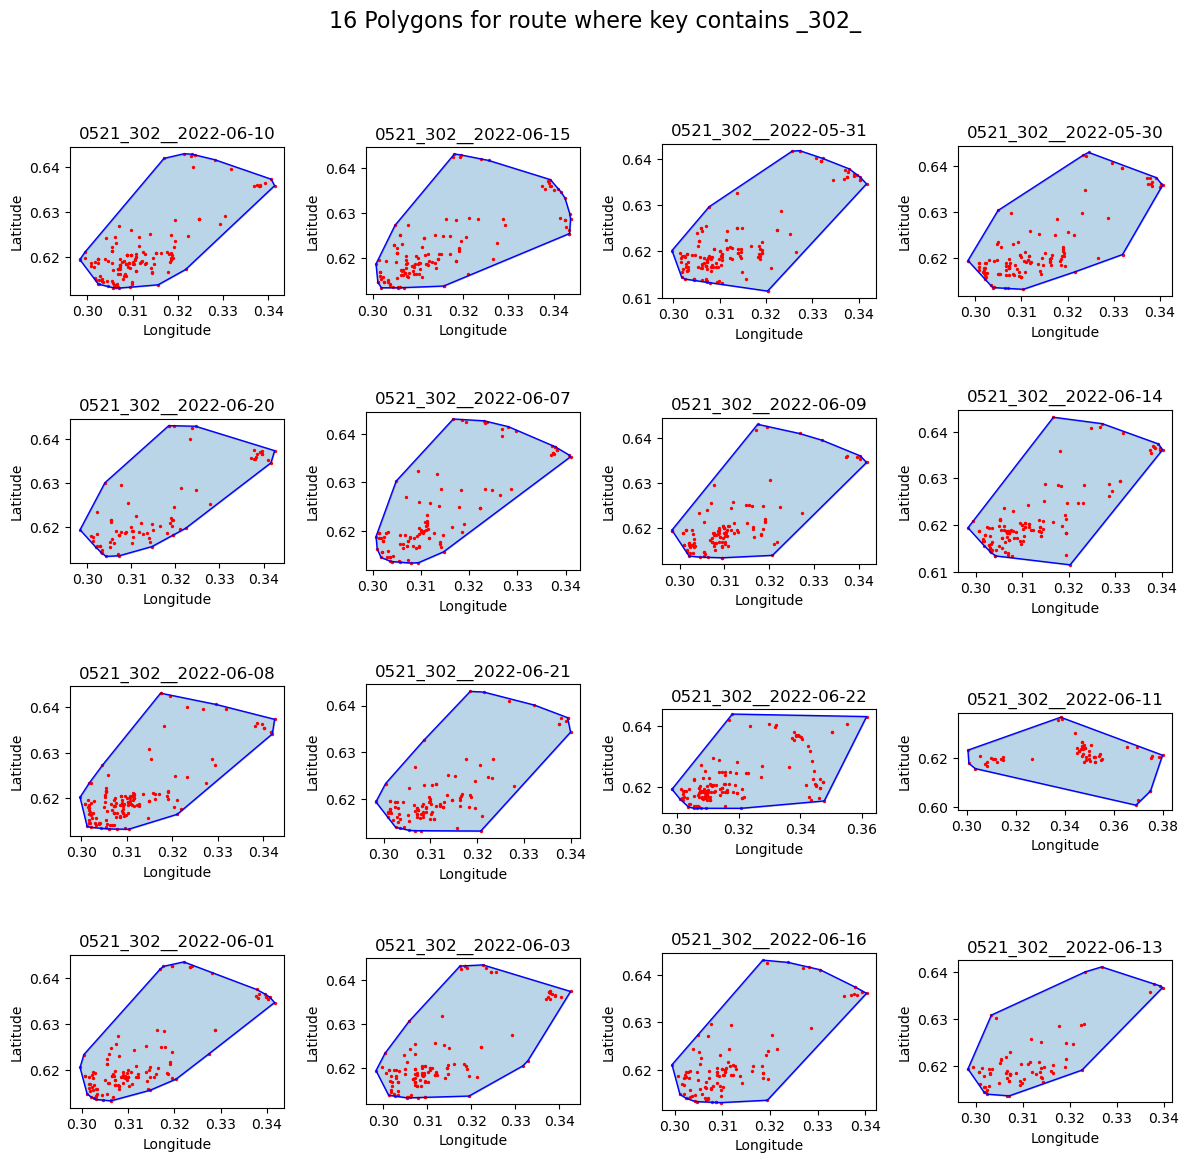

In [15]:
rpm.plot_random_polygons_grid(4, keyname = dayroutename, key_contains='_302_', plot_points=True)

The above plot is interesting, it proves that polygons taking in account the whole dataset will include outliers (see the routes for 31 and 17, there are clear far-points in there. )

## Let's make unions of those polygons based on common surface area. 

In [16]:
#We want to crop away zones of the route_polygon that is not 90% of the time in route_day_polygons. We overlay 
# all the route_day_polygons on top of each other and store a new polygon that with surva area that is covered by 
# 90% of the route_day_polygons. BEWARE; theoretically you run the risk of making MULTIPOLGYON objects. This does
# not really affect our use case. 
for route_id in merged_df.route_id: 
    #get route-day-keys from rpm:
    common_poly = rpm.overlay_polygons( 1, dayroutename, route_id)

Text(95.68858100223422, 0.5, 'Latitude')

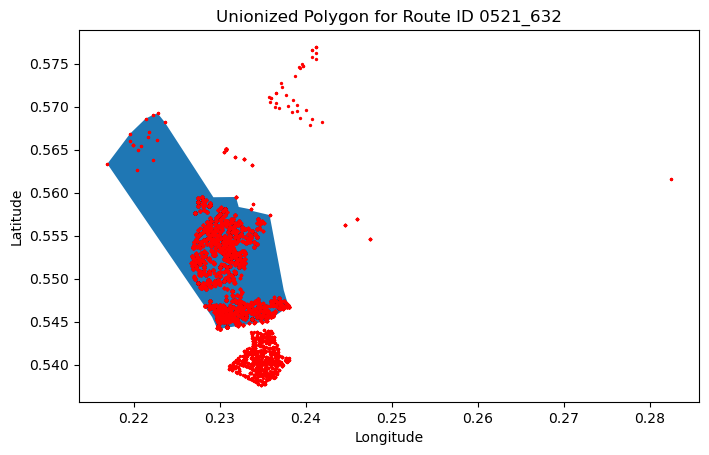

In [24]:

# If it's a single Polygon object, convert it into a GeoSeries for plotting

route_id = np.random.choice(request_df.route_id.unique())

polygon = rpm.unionized_poly[route_id]
points = []
polygon_series = gpd.GeoSeries(polygon)

# Plot the Polygon
fig, ax = plt.subplots(figsize=(8, 8))
polygon_series.plot(ax=ax)
tiny_df = request_df.query('route_id==@route_id')
for _, row in tiny_df.iterrows():
    points.append([row['long'], row['lat']])
ax.scatter(x = tiny_df.long, y = tiny_df.lat, s=2, c='red')
ax.set_title(f"Unionized Polygon for Route ID {route_id}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


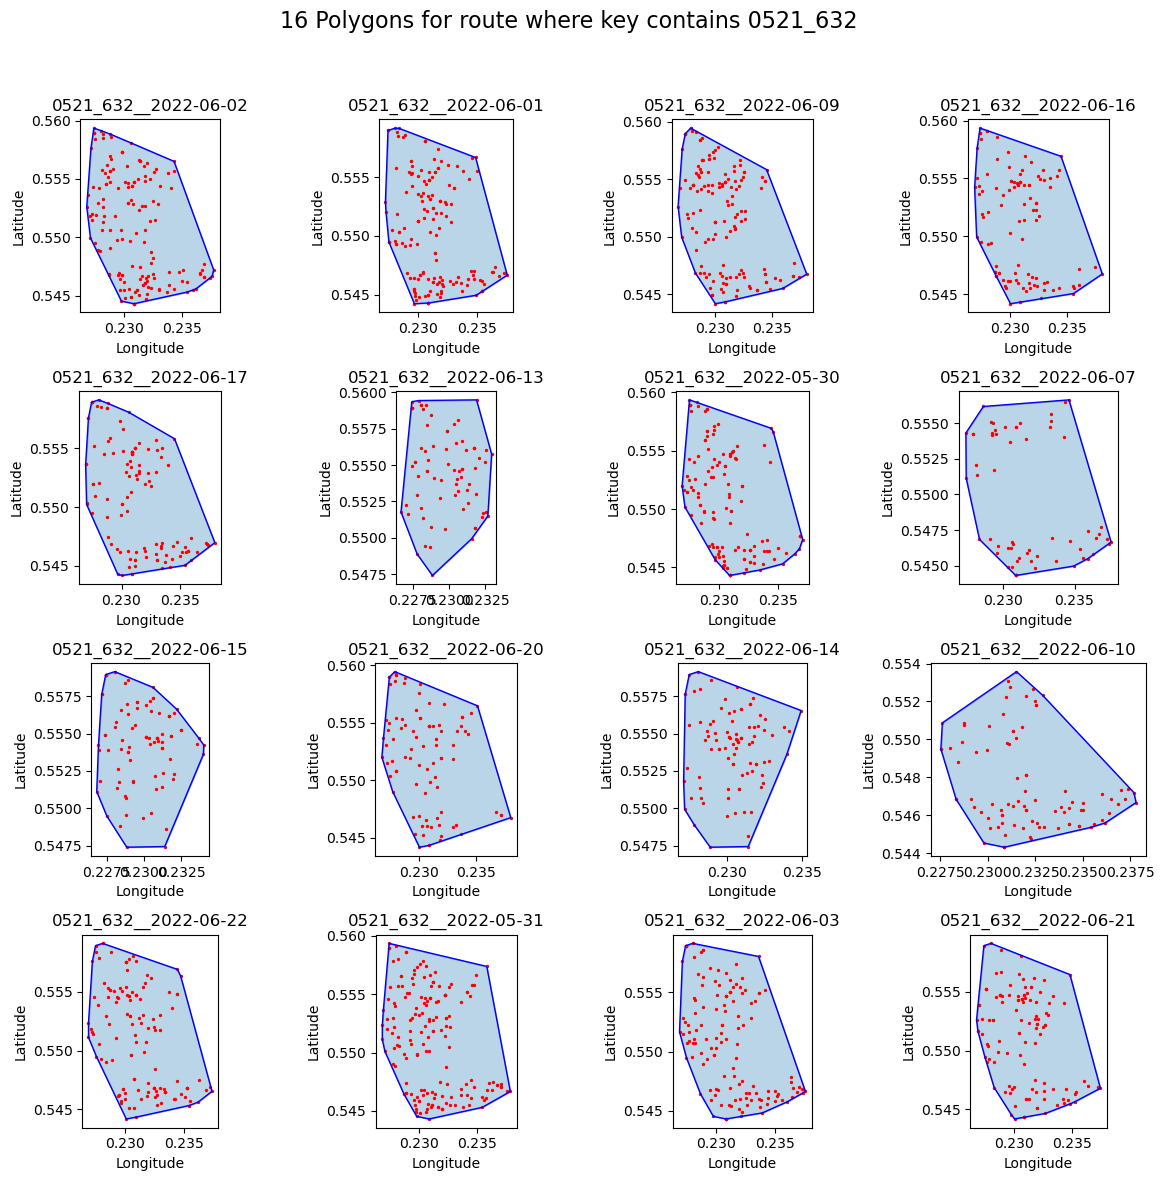

In [25]:
rpm.plot_random_polygons_grid(4, keyname = dayroutename, key_contains=route_id, plot_points=True)

In [26]:
reduced_polygon = rpm.reduce_polygon(polygon, points, route_id, tolerance=0.1, eps=0.0002, min_samples= 75)

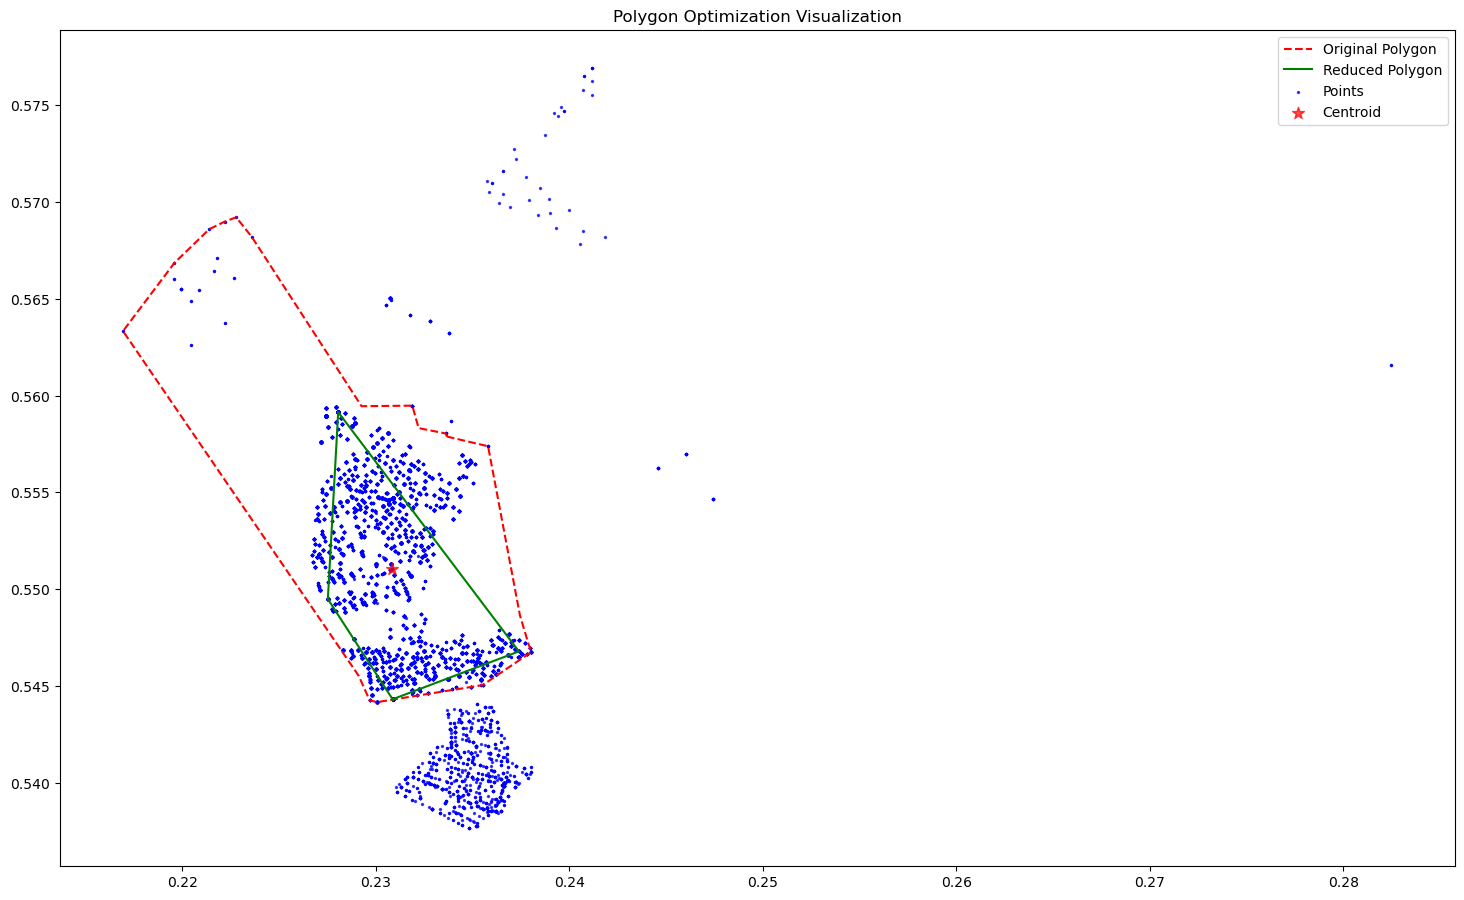

In [31]:
rpm.plot_optimized_polygon(polygon, reduced_polygon, points, route_id)

In [32]:
for route_id in tqdm(merged_df.route_id.unique()): 
    #Build data for polygon in each loop step: 
    polygon = rpm.unionized_poly[route_id]
    points = []
    polygon_series = gpd.GeoSeries(polygon)
    tiny_df = request_df.query('route_id==@route_id')
    for _, row in tiny_df.iterrows():
        points.append([row['long'], row['lat']])
    #Reduce the polygon: 
    reduced_polygon = rpm.reduce_polygon(polygon, points, route_id, tolerance=0.1, eps=0.001, min_samples= 75)


100%|██████████| 232/232 [16:16<00:00,  4.21s/it] 


# Show the results of polygon reduction: 
You want to have a plot with each polygon plotted out this should be nbetter than the Picasso stuff we got initially. 

In [42]:

def plot_polygons_with_ids(polygon_dict):
    """
    Plots polygons in a 2D space using Plotly. Clicking on a polygon displays its ID.

    Args:
        polygon_dict (dict): A dictionary where keys are IDs and values are Shapely Polygon objects.
    """
    # Create a list to store data for Plotly
    data = []

    for polygon_id, polygon in polygon_dict.items():
        # Convert the polygon to GeoJSON format
        geojson_polygon = mapping(polygon)
        # Add the polygon and its ID to the data list
        data.append(go.Scatter(
            x=[coord[0] for coord in geojson_polygon['coordinates'][0]],
            y=[coord[1] for coord in geojson_polygon['coordinates'][0]],
            fill="toself",
            text=polygon_id,  # Display the ID when clicked
            hoverinfo="text",
            mode="lines",
            line=dict(width=2, color="blue"),
            name=polygon_id
        ))

    # Create the layout
    layout = go.Layout(
        title="2D Polygon Plot",
        showlegend=False,
        xaxis=dict(showgrid=False),  # Disable grid on x-axis
        yaxis=dict(showgrid=False),  # Disable grid on y-axis
        width=1600,  # Set the figure width (18 inches, with 100 px per inch)
        height=900,  # Set the figure height (18 inches, with 100 px per inch)
    )

    # Create the figure
    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()



plot_polygons_with_ids(rpm.reduced_poly)

## We have polygons now that are reduced next step: 
Rebuild routes: 
- put all points for day X on a map and project them onto polygons
- For all polygons that match, find the closest points of non day X days; assume that the polygon that has those closest points is the service-polygon.  
- With all points assigned to a service-polygon: build the routes. 
- Compare the metric. 

In [36]:
print('Choose a day: ')
driven_df.route_date.unique()

Choose a day: 


array(['2022-06-21', '2022-06-17', '2022-06-08', '2022-06-13',
       '2022-06-07', '2022-06-10', '2022-06-01', '2022-06-14',
       '2022-06-15', '2022-05-31', '2022-06-04', '2022-06-03',
       '2022-06-02', '2022-05-30', '2022-06-16', '2022-06-20',
       '2022-06-22', '2022-06-09', '2022-06-18', '2022-06-11'],
      dtype=object)

In [37]:
day = "2022-06-13"

###leave below section alone: 

day_df = driven_df.query('route_date==@day').copy()

In [38]:
day_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,RouteId,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last,dist_since_prev,dist_cumulative,dist_to_next_stop
1507072,004d24a9-8c75-4806-9a6d-2e7f9f2d7ad4,EstimateTime,38929,0.633046,0.234020,2022-06-13T07:00:00,2022-06-13T18:00:00,1,1,0521_867-20220613,...,0521_867,TimeCalculation,EstimateTime,95.0,95.0,9.0,True,0.000000,0.000000,0.005446
1507073,004d24a9-8c75-4806-9a6d-2e7f9f2d7ad4,EstimateTime,38928,0.627880,0.235744,2022-06-13T07:00:00,2022-06-13T18:00:00,2,2,0521_867-20220613,...,0521_867,TimeCalculation,EstimateTime,95.0,95.0,9.0,True,0.005446,0.005446,0.007238
1507074,004d24a9-8c75-4806-9a6d-2e7f9f2d7ad4,EstimateTime,38958,0.627544,0.228514,2022-06-13T07:00:00,2022-06-13T18:00:00,3,3,0521_867-20220613,...,0521_867,TimeCalculation,EstimateTime,95.0,95.0,9.0,True,0.007238,0.012684,0.002748
1507075,004d24a9-8c75-4806-9a6d-2e7f9f2d7ad4,EstimateTime,38944,0.629982,0.229780,2022-06-13T07:00:00,2022-06-13T18:00:00,4,4,0521_867-20220613,...,0521_867,TimeCalculation,EstimateTime,95.0,95.0,9.0,True,0.002748,0.015432,0.001558
1507076,004d24a9-8c75-4806-9a6d-2e7f9f2d7ad4,EstimateTime,38949,0.629546,0.231276,2022-06-13T07:00:00,2022-06-13T18:00:00,5,5,0521_867-20220613,...,0521_867,TimeCalculation,EstimateTime,95.0,95.0,9.0,True,0.001558,0.016990,0.017459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251821,ff154cf6-a531-4a97-88de-e757c8e5b6f6,EstimateTime,130478,0.501878,0.181730,2022-06-13T07:30:00,2022-06-13T19:00:00,188,188,0521_358-20220613,...,0521_358,TimeCalculation,EstimateTime,192.0,192.0,8.0,True,0.000000,0.196826,0.000000
251822,ff154cf6-a531-4a97-88de-e757c8e5b6f6,EstimateTime,130509,0.501878,0.181730,2022-06-13T07:30:00,2022-06-13T19:00:00,189,189,0521_358-20220613,...,0521_358,TimeCalculation,EstimateTime,192.0,192.0,8.0,True,0.000000,0.196826,0.000000
251823,ff154cf6-a531-4a97-88de-e757c8e5b6f6,EstimateTime,130676,0.501878,0.181730,2022-06-13T16:00:00,2022-06-13T18:00:00,190,190,0521_358-20220613,...,0521_358,TimeCalculation,EstimateTime,192.0,192.0,8.0,True,0.000000,0.196826,0.008655
251824,ff154cf6-a531-4a97-88de-e757c8e5b6f6,EstimateTime,130686,0.497506,0.189200,2022-06-13T00:00:00,2022-06-13T23:59:00,191,191,0521_358-20220613,...,0521_358,TimeCalculation,EstimateTime,192.0,192.0,8.0,True,0.008655,0.205481,0.011309


In [39]:
#Thank you chatgpt

def euclidean_distance(p1, p2):
    return math.hypot(p2[0] - p1[0], p2[1] - p1[1])

def create_distance_matrix(points):
    size = len(points)
    matrix = [[0] * size for _ in range(size)]
    for i in range(size):
        for j in range(size):
            if i != j:
                matrix[i][j] = euclidean_distance(points[i], points[j])
    return matrix

def solve_tsp(points):
    # Identify the most southwest point
    start_index = min(range(len(points)), key=lambda i: (points[i][1], points[i][0]))

    distance_matrix = create_distance_matrix(points)
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, start_index)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        return int(distance_matrix[manager.IndexToNode(from_index)][manager.IndexToNode(to_index)] * 1000)  # scale to int

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Set search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        index = routing.Start(0)
        route = []
        total_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(points[node_index])
            next_index = solution.Value(routing.NextVar(index))
            total_distance += distance_matrix[node_index][manager.IndexToNode(next_index)]
            index = next_index
        return total_distance, route
    else:
        return None, []


In [41]:
# points = [(1, 2), (3, 4), (0, 1), (5, 1), (2, 3), (6, 0), (1, 5), (4, 3)]
# distance, route = solve_tsp(points)

# print(f"Shortest path distance: {distance:.2f}")
# print("Route:")
# for p in route:
#     print(p)

##Use your custom fuction to calculate distances on day_df per route as routes are plotted now
# since we de not have access to the server-algo that calculated the original order of points, we
# will use our own function so we can compare a metric: 

distances_of_original_routes = {}

for route_id, route_day_df in tqdm(day_df.groupby('route_id')): 
    points = list(zip(route_day_df['lat'], route_day_df['long']))
    distance, route = solve_tsp(points)
    distances_of_original_routes[route_id] = distance
    

100%|██████████| 178/178 [00:34<00:00,  5.16it/s]


In [42]:
np.mean(list(distances_of_original_routes.values()))

0.12985030856002938

### Baseline is known: distance is 0.12985 potatoes; can we do it better

In [49]:
#we'll be assigning each pointcoordinate to a polygon.
# If we have multiple polygons, we award the point to the to polygon which 
# has it's center the closest to the point. 

cluster_ids = []
for _, row in tqdm(day_df.iterrows()): 
    row_lat, row_long = row['lat'], row['long']
    cluster_ids.append(rpm.get_polygons_containing_coordinate([row_lat, row_long], rpm.reduced_poly))
day_df['cluster_id'] = cluster_ids


19022it [00:51, 371.58it/s]


In [50]:
day_df.cluster_id.value_counts()

cluster_id
0521_B09    3510
0521_B08    2344
0521_B07    1359
0521_B13     597
0521_O29     586
            ... 
0521_681       2
0521_633       1
0521_318       1
0521_O41       1
0521_O10       1
Name: count, Length: 139, dtype: int64

In [51]:
distances_of_remix_routes = {}

for route_id, route_day_df in tqdm(day_df.groupby('cluster_id')): 
    points = list(zip(route_day_df['lat'], route_day_df['long']))
    distance, route = solve_tsp(points)
    distances_of_remix_routes[route_id] = distance

100%|██████████| 139/139 [1:03:54<00:00, 27.59s/it]   


In [52]:
print('Mean length of original routes ', np.mean(list(distances_of_original_routes.values())))
print('Mean length of remix routes ', np.mean(list(distances_of_remix_routes.values())))

Mean length of original routes  0.12985030856002938
Mean length of remix routes  0.1839353880232404


In [53]:
print('Total length of original routes ', np.sum(list(distances_of_original_routes.values())))
print('Total length of remix routes ', np.sum(list(distances_of_remix_routes.values())))

Total length of original routes  23.11335492368523
Total length of remix routes  25.567018935230415


In [54]:
print(len(distances_of_original_routes.keys()))
print(len(distances_of_remix_routes.keys()))

178
139


let's try another approach